In [2]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "04_problem_types/10g_scann_search.ipynb"
_nb_title = "Searching for embeddings"
_nb_message = """
This notebook shows you how to use embeddings and SCaNN to implement fast image search.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Searching+for+embeddings&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F04_problem_types%2F10g_scann_search.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/04_problem_types/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Searching for embeddings</h1>
This notebook shows you how to use embeddings and SCaNN to implement fast image search.


## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [9]:
%pip install --quiet scann

In [1]:
import scann
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


## Create index of embeddings

Use a pre-trained MobileNet model to create embeddings
of 100 images in the flowers dataset.

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 2
NUM_IMAGES = 100
NUM_NEIGH = 3 # top 3

def read_and_decode(filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH]):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  return filename, img

In [3]:
layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Flatten()
]
model = tf.keras.Sequential(layers, name='flowers_embedding')
print(model.summary())

Model: "flowers_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [4]:
def create_embeddings_dataset(csvfilename, num_images):
  ds = (tf.data.TextLineDataset(csvfilename).
        map(decode_csv).take(num_images).batch(BATCH_SIZE))
  dataset_filenames = []
  dataset_embeddings = []
  for filenames, images in ds:
    embeddings = model.predict(images)
    dataset_filenames.extend([f.numpy().decode('utf-8') for f in filenames])
    dataset_embeddings.extend(embeddings)
  dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
  return dataset_filenames, dataset_embeddings

dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    "gs://cloud-ml-data/img/flower_photos/train_set.csv", NUM_IMAGES
)
print(dataset_filenames[:3])
print(dataset_embeddings.shape) # should be (NUM_IMAGES, 1280)

['gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg']
(100, 1280)


In [5]:
query_filenames, query_embeddings = create_embeddings_dataset(
    "gs://cloud-ml-data/img/flower_photos/eval_set.csv", BATCH_SIZE
)
print(query_embeddings.shape)

(2, 1280)


In [6]:
## Create SCaNN searcher
searcher = scann.scann_ops.builder(dataset_embeddings, NUM_NEIGH, "dot_product").score_ah(2).build()

In [9]:
neighbors, distances = searcher.search_batched(query_embeddings)
print(neighbors)
print(distances)

tf.Tensor(
[[36 42 11]
 [95 26 27]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[390.5544  379.76315 356.1111 ]
 [457.37054 362.76993 336.50095]], shape=(2, 3), dtype=float32)


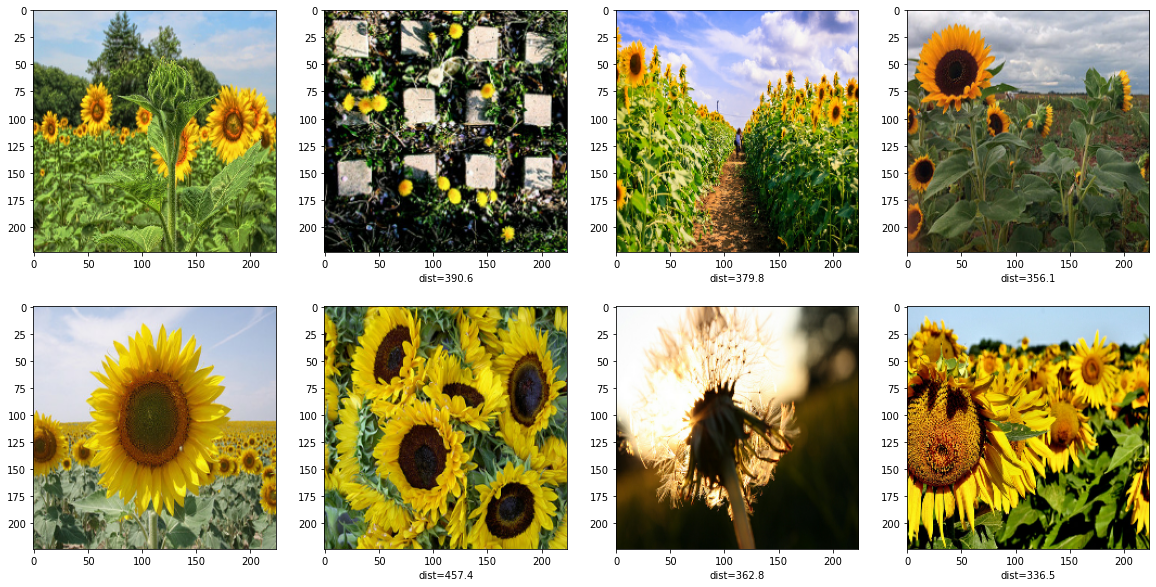

In [11]:
f, ax = plt.subplots(len(query_filenames), NUM_NEIGH + 1,
                     figsize=(5 * (1 + NUM_NEIGH), 5 * len(query_filenames)))
for rowno, query_filename in enumerate(query_filenames):
  ax[rowno][0].imshow(read_and_decode(query_filename).numpy())
  for colno, neigh in enumerate(neighbors[rowno]):
    ax[rowno][colno+1].imshow(read_and_decode(dataset_filenames[neigh]).numpy())
    ax[rowno][colno+1].set_xlabel('dist={:.1f}'.format(distances[rowno][colno].numpy()))

## Plots for book

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.